In [1]:
from scipy import sparse
import numpy as np
from sklearn.model_selection import train_test_split

import torch
import torch.nn as nn
import torch.nn.functional as F

from matplotlib import pyplot as plt
import os
import time
import copy
import torch.optim as optim

from utils import *
from models import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)

In [2]:
test_size = 0.9
lr = 0.005
emb_dim = 64
dropout_rate = 0.1
weight_decay = 0.0001
epochs = 100
batch_size = 512
milestones = [10, 40, 60, 80]
model_origin = NGCF
model_ours = NGCF

category_rate = 1

In [3]:
ml100k_user = sparse.load_npz('./citeulike_19core/citeulike_user_item_19core.npz')
ml100k_item = sparse.load_npz('./citeulike_19core/citeulike_item_tags_19core.npz')
print(ml100k_user.shape, ml100k_item.shape)
# 유저, 아이템 인덱스가 1부터 시작하는 데이터로 만들어서 모양이 943, 1682에서 1씩 큼. 인덱스를 0으로 시작하도록 만들어 주는 코드가 아래 한 줄
# ml100k_user = sparse.csr_matrix((ml100k_user.data, np.array([_-1 for _ in ml100k_user.indices]), ml100k_user.indptr[1:]), shape = (ml100k_user.shape[0] - 1, ml100k_user.shape[1] - 1) )

# 각 edge가 1~5로 매칭되어 있는 부분을 전부 1로 변환
ml100k_user.data = np.ones_like(ml100k_user.data)

# 학습용, 평가용 나누기
H_u_train, H_u_test = split_per_one_user(ml100k_user, test_size_ = test_size, use_ranking = False)

(3277, 16807) (16807, 46391)


In [4]:
# ngcf conv에서 계산할때 사용할 normalized adjacent matrix 계산
H_u_train_ = sps2torchsparse(H_u_train)
H_i = sps2torchsparse(ml100k_item)
norm_Adj = Generate_norm_Adj(H_u_train_, torch.zeros_like(H_i), category_rate).to_dense().to(device)
norm_Adj2 = Generate_norm_Adj(H_u_train_, H_i, category_rate).to_dense().to(device)
# 모델 구성
model = model_origin(in_ch = norm_Adj.shape[0], emb_ch = emb_dim, dropout_rate=dropout_rate).to(device)
model2 = model_ours(in_ch = norm_Adj.shape[0], emb_ch = emb_dim, dropout_rate=dropout_rate).to(device)
metric = mymetric()

optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.5)
optimizer2 = optim.Adam(model2.parameters(), lr = lr, weight_decay=weight_decay)
scheduler2 = optim.lr_scheduler.MultiStepLR(optimizer2, milestones=milestones, gamma=0.5)

criterion = bpr_loss
criterion2 = bpr_loss

gt = ml100k_user.toarray()

inputs = torch.arange(ml100k_user.shape[0] + ml100k_user.shape[1]).to(device)

In [5]:
# model training
running_losses, val_losses = [], []
running_losses2, val_losses2 = [], []
val_acc = {'ndcg' : [], 'recall' : [], 'precision' : []}
val_acc2 = {'ndcg' : [], 'recall' : [], 'precision' : []}

n_user = H_u_train.shape[0]

# norm_Adj_droped = norm_Adj
# norm_Adj_droped2 = norm_Adj2

for epoch in range(epochs):
    start_time = time.time()
    running_loss, val_loss = 0, 0
    running_loss2, val_loss2 = 0, 0

    H_droped = first_dropout(H_u_train_, dropout_rate=dropout_rate)
    norm_Adj_droped = Generate_norm_Adj(H_droped, torch.zeros_like(H_i), category_rate).to_dense().to(device)
    norm_Adj_droped2 = Generate_norm_Adj(H_droped, H_i, category_rate).to_dense().to(device)

    model.train()
    model2.train()
    with torch.set_grad_enabled(True):
        for u,p,n in data_generator(H_u_train, batch_size):
            optimizer.zero_grad()
            optimizer2.zero_grad()
            final_emb = model(inputs, norm_Adj_droped)
            final_emb2 = model2(inputs, norm_Adj_droped2)

            users = torch.index_select(final_emb, 0, torch.tensor(u).to(device))
            pos_items = torch.index_select(final_emb, 0, (torch.tensor(p).long() + n_user).to(device))
            neg_items = torch.index_select(final_emb, 0, (torch.tensor(n).long() + n_user).to(device))
            users2 = torch.index_select(final_emb2, 0, torch.tensor(u).to(device))
            pos_items2 = torch.index_select(final_emb2, 0, (torch.tensor(p).long() + n_user).to(device))
            neg_items2 = torch.index_select(final_emb2, 0, (torch.tensor(n).long() + n_user).to(device))
            
            batch_loss, batch_mf_loss, batch_emb_loss = criterion(users, pos_items=pos_items, neg_items=neg_items)
            batch_loss2, batch_mf_loss2, batch_emb_loss2 = criterion2(users2, pos_items=pos_items2, neg_items=neg_items2)

            batch_loss.backward()
            batch_loss2.backward()
            optimizer.step()
            optimizer2.step()

            running_loss += batch_loss.item()
            running_loss2 += batch_loss2.item()
    running_losses.append(running_loss)
    running_losses2.append(running_loss2)
    scheduler.step()
    scheduler2.step()

    model.eval()
    model2.eval()
    with torch.set_grad_enabled(False):
        for u,p,n in data_generator(H_u_test, batch_size):
            final_emb = model(inputs, norm_Adj)
            final_emb2 = model2(inputs, norm_Adj2)

            users = torch.index_select(final_emb, 0, torch.tensor(u).to(device))
            pos_items = torch.index_select(final_emb, 0, (torch.tensor(p).long() + n_user).to(device))
            neg_items = torch.index_select(final_emb, 0, (torch.tensor(n).long() + n_user).to(device))
            users2 = torch.index_select(final_emb2, 0, torch.tensor(u).to(device))
            pos_items2 = torch.index_select(final_emb2, 0, (torch.tensor(p).long() + n_user).to(device))
            neg_items2 = torch.index_select(final_emb2, 0, (torch.tensor(n).long() + n_user).to(device))
            
            batch_loss, batch_mf_loss, batch_emb_loss = criterion(users, pos_items=pos_items, neg_items=neg_items)
            batch_loss2, batch_mf_loss2, batch_emb_loss2 = criterion2(users2, pos_items=pos_items2, neg_items=neg_items2)

            val_loss += batch_loss.item()
            val_loss2 += batch_loss2.item()
        rec = np.array((final_emb[:n_user] @ final_emb[n_user:].T).detach().to('cpu'))
        rec2 = np.array((final_emb2[:n_user] @ final_emb2[n_user:].T).detach().to('cpu'))
        for i in range(H_u_train.shape[0]):
            train_indices = H_u_train[i].indices
            rec[i][train_indices] = -1024
            rec2[i][train_indices] = -1024

        val_ndcg = metric._ndcg(rec = rec, gt = ml100k_user, k=20)
        val_recall = metric._recall(rec = rec, gt = ml100k_user, k=20)
        val_ndcg2 = metric._ndcg(rec = rec2, gt = ml100k_user, k=20)
        val_recall2 = metric._recall(rec = rec2, gt = ml100k_user, k=20)
        val_precision = metric._precision(rec = rec, gt = ml100k_user, k=20)
        val_precision2 = metric._precision(rec = rec2, gt = ml100k_user, k=20)
    val_losses.append(val_loss)
    val_acc['ndcg'].append(val_ndcg)
    val_acc['recall'].append(val_recall)
    val_acc['precision'].append(val_precision)
    val_losses2.append(val_loss2)
    val_acc2['ndcg'].append(val_ndcg2)
    val_acc2['recall'].append(val_recall2)
    val_acc2['precision'].append(val_precision2)

    if (epoch + 1) % 10 == 0:
        print('Epoch : {}, running_loss : {:.6f}, val_loss : {:.6f}, time : {:.2f}'.format(epoch + 1, running_loss, val_loss, time.time() - start_time))
        print('NDCG : {:.6f}, Recall : {:.6f}, Precision : {:.6f}'.format(np.mean(val_ndcg), np.mean(val_recall), np.mean(val_precision)))
        print('Epoch : {}, running_loss2 : {:.6f}, val_loss2 : {:.6f}, time : {:.2f}'.format(epoch + 1, running_loss2, val_loss2, time.time() - start_time))
        print('NDCG2 : {:.6f}, Recall2 : {:.6f}, Precision2 : {:.6f}'.format(np.mean(val_ndcg2), np.mean(val_recall2), np.mean(val_precision2)))
        print('-' * 60)

Epoch : 10, running_loss : 0.708224, val_loss : 6.724639, time : 87.49
NDCG : 0.016108, Recall : 0.004848, Precision : 0.015929
Epoch : 10, running_loss2 : 1.928473, val_loss2 : 5.753208, time : 87.49
NDCG2 : 0.025298, Recall2 : 0.007109, Precision2 : 0.023207
------------------------------------------------------------
Epoch : 20, running_loss : 0.591337, val_loss : 6.460900, time : 115.74
NDCG : 0.022015, Recall : 0.006351, Precision : 0.021239
Epoch : 20, running_loss2 : 1.267964, val_loss2 : 5.820274, time : 115.74
NDCG2 : 0.025926, Recall2 : 0.007389, Precision2 : 0.024550
------------------------------------------------------------
Epoch : 30, running_loss : 0.557119, val_loss : 6.376747, time : 98.67
NDCG : 0.027543, Recall : 0.007784, Precision : 0.025664
Epoch : 30, running_loss2 : 1.144663, val_loss2 : 5.804566, time : 98.67
NDCG2 : 0.029964, Recall2 : 0.008758, Precision2 : 0.027556
------------------------------------------------------------
Epoch : 40, running_loss : 0.500

train losses


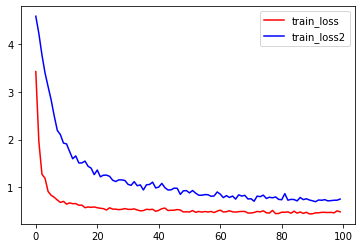

val losses


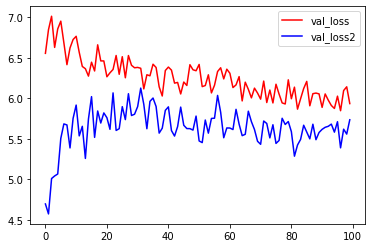

val ndcg


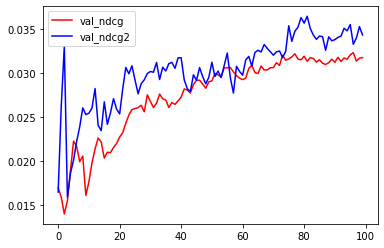

val recall


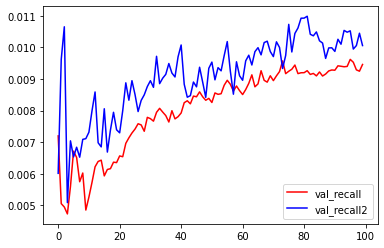

val precision


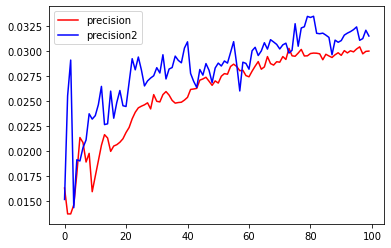

val max ndcg, recall
0.03234704215242475
0.036483713055121846
0.009618997872020434
0.010984800504145105
0.03045468416234361
0.03352151357949344
val last ndcg, recall
0.03177452623750828
0.03435319840517461
0.009457507620196384
0.010056637678106222
0.03002746414403418
0.03153799206591395


In [7]:
def ploting_list(one_dim_list, c = 'b', label = 'metric'):
    length = len(one_dim_list)
    plt.plot(range(length), one_dim_list, c = c, label = label)

print('train losses')
ploting_list(running_losses, 'r', 'train_loss')
ploting_list(running_losses2, 'b', 'train_loss2')
plt.legend()
plt.show()

print('val losses')
ploting_list(val_losses, 'r', 'val_loss')
ploting_list(val_losses2, 'b', 'val_loss2')
plt.legend()
plt.show()

print('val ndcg')
ploting_list([np.mean(i) for i in val_acc['ndcg']], 'r', 'val_ndcg')
ploting_list([np.mean(i) for i in val_acc2['ndcg']], 'b', 'val_ndcg2')
plt.legend()
plt.show()

print('val recall')
ploting_list([np.mean(i) for i in val_acc['recall']], 'r', 'val_recall')
ploting_list([np.mean(i) for i in val_acc2['recall']], 'b', 'val_recall2')
plt.legend()
plt.show()

print('val precision')
ploting_list([np.mean(i) for i in val_acc['precision']], 'r', 'precision')
ploting_list([np.mean(i) for i in val_acc2['precision']], 'b', 'precision2')
plt.legend()
plt.show()

print('val max ndcg, recall')
print(np.max([np.mean(i) for i in val_acc['ndcg']]))
print(np.max([np.mean(i) for i in val_acc2['ndcg']]))
print(np.max([np.mean(i) for i in val_acc['recall']]))
print(np.max([np.mean(i) for i in val_acc2['recall']]))
print(np.max([np.mean(i) for i in val_acc['precision']]))
print(np.max([np.mean(i) for i in val_acc2['precision']]))
print('val last ndcg, recall')
print([np.mean(i) for i in val_acc['ndcg']][-1])
print([np.mean(i) for i in val_acc2['ndcg']][-1])
print([np.mean(i) for i in val_acc['recall']][-1])
print([np.mean(i) for i in val_acc2['recall']][-1])
print([np.mean(i) for i in val_acc['precision']][-1])
print([np.mean(i) for i in val_acc2['precision']][-1])